# Неиерархические методы кластеризации

## Введение
Кластеризация — это метод машинного обучения без учителя, используемый для группировки объектов в наборе данных на основе их сходства. Существует два основных подхода к кластеризации: **иерархический** и **неиерархический**. В данном отчёте мы сосредоточимся на неиерархических методах, сравним их с иерархическими и рассмотрим их преимущества и недостатки.

## Иерархические методы кластеризации
Иерархические методы делятся на два типа:
1. **Агломеративные (снизу вверх)**: начинают с отдельных объектов как кластеров и постепенно объединяют их в более крупные группы на основе меры сходства (например, евклидова расстояния).
2. **Дивизивные (сверху вниз)**: начинаются с одного кластера, содержащего все объекты, и делят его на меньшие кластеры.

Иерархические методы создают **дендрограмму** — древовидную структуру, которая позволяет выбрать количество кластеров post hoc. Однако они имеют высокую вычислительную сложность (O(n²) или O(n³)), что делает их менее эффективными для больших наборов данных.

## Неиерархические методы кластеризации
Неиерархические методы, напротив, не строят иерархию, а напрямую разделяют данные на заданное количество кластеров. Основные представители:
1. **K-Means**: разделяет данные на k кластеров, минимизируя внутрикластерную дисперсию.
2. **DBSCAN**: кластеризует данные на основе плотности, выделяя области с высокой плотностью точек.
3. **Mean Shift**: адаптивно находит кластеры, сдвигая центроиды к областям максимальной плотности.
4. **Gaussian Mixture Models (GMM)**: предполагает, что данные порождены смесью гауссовых распределений.
5. **Spectral Clustering**: использует спектральные свойства матрицы сходства для разделения данных.

## Сравнение с иерархическими методами

| Характеристика            | Неиерархические методы                  | Иерархические методы                   |
|---------------------------|-----------------------------------------|----------------------------------------|
| **Заданное число кластеров** | Требуется (кроме DBSCAN, Mean Shift)   | Не требуется, определяется из дендрограммы |
| **Вычислительная сложность** | Обычно ниже (O(n) для K-Means)         | Выше (O(n²) или O(n³))                |
| **Гибкость формы кластеров** | Ограничена (K-Means — сферические)     | Более гибкая                          |
| **Устойчивость к шуму**    | Зависит от метода (DBSCAN устойчив)    | Обычно чувствительны                  |
| **Интерпретируемость**     | Простая для K-Means, сложнее для GMM    |	Высокая благодаря дендрограмме    |

# Простая реализация неиерархических методов на примере датасета Wine

## Подготовка данных

In [32]:
# Импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, MeanShift, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

In [2]:
# Загрузка датасета вин
wine = load_wine()
X = wine.data
y = wine.target  # Истинные метки для оценки
feature_names = wine.feature_names

In [3]:
# Стандартизация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

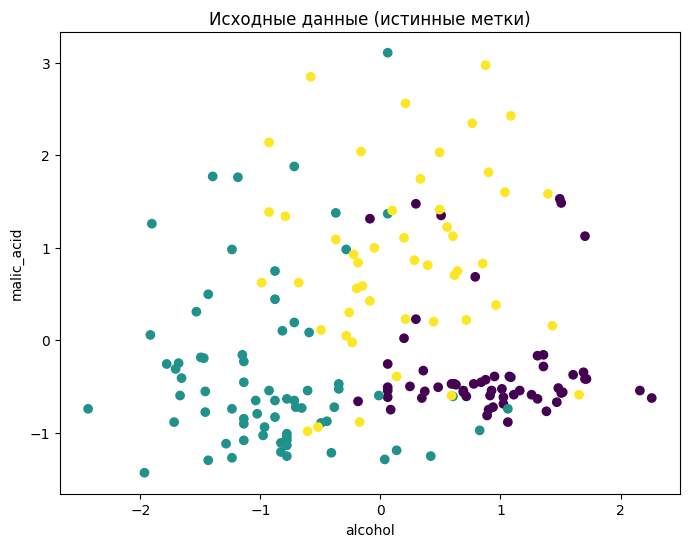

In [4]:
# Визуализация исходных данных (первые две фичи для простоты)
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap='viridis')
plt.title('Исходные данные (истинные метки)')
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.show()

## K-Means: Пошаговая реализация и анализ

### Описание метода
K-Means — это неиерархический метод кластеризации, который разделяет данные на k кластеров, минимизируя внутрикластерную дисперсию. Алгоритм предполагает, что кластеры имеют сферическую форму и схожий размер.

#### Математические основы
1. **Целевая функция (сумма квадратов внутрикластерных расстояний):**  
   Цель K-Means — минимизировать сумму квадратов расстояний от каждой точки до центра её кластера. Это можно записать как J, где J — сумма по всем кластерам i от 1 до k, а внутри каждого кластера — сумма квадратов расстояний от точек x до центроида μ_i.

2. **Обновление центроидов:**  
   Центроид μ_i для кластера i вычисляется как среднее значение всех точек x, принадлежащих этому кластеру. Формула: μ_i = (сумма x в кластере i) / (число точек в кластере i).

#### Алгоритм пошагово
1. Инициализировать k центроидов случайным образом.
2. Назначить каждую точку данных ближайшему центроиду (по евклидову расстоянию).
3. Пересчитать центроиды как среднее значение точек в каждом кластере.
4. Повторять шаги 2–3, пока центроиды не перестанут изменяться (или не будет достигнуто максимальное число итераций).

### Преимущества
- Простота и скорость (сложность O(n * k * i), где n — число точек, k — число кластеров, i — число итераций).
- Хорошо работает с компактными, сферическими кластерами.

### Недостатки
- Требует заранее заданного k.
- Чувствителен к начальной инициализации центроидов.
- Плохо справляется с кластерами сложной формы или разного размера.

In [18]:
# 1. K-Means
# Функция для вычисления евклидова расстояния
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2))

# Пошаговая реализация K-Means
def kmeans_step_by_step(X, k, max_iters=100, random_seed=42):
    np.random.seed(random_seed)
    n_samples = X.shape[0]
    
    # 1. Случайная инициализация центроидов
    idx = np.random.choice(n_samples, k, replace=False)
    centroids = X[idx]
    
    # Список для хранения истории центроидов и меток
    history = {'centroids': [centroids.copy()], 'labels': []}
    iteration_count = 0
    
    for _ in range(max_iters):
        # 2. Назначение точек ближайшему центроиду
        labels = np.zeros(n_samples)
        for i, x in enumerate(X):
            distances = [euclidean_distance(x, centroid) for centroid in centroids]
            labels[i] = np.argmin(distances)
        
        # Сохраняем метки
        history['labels'].append(labels.copy())
        
        # 3. Пересчёт центроидов
        new_centroids = np.zeros((k, X.shape[1]))
        for j in range(k):
            cluster_points = X[labels == j]
            if len(cluster_points) > 0:  # Проверка на пустые кластеры
                new_centroids[j] = cluster_points.mean(axis=0)
            else:
                new_centroids[j] = centroids[j]  # Оставляем старый центроид
        
        # Сохраняем новые центроиды
        history['centroids'].append(new_centroids.copy())
        
        # 4. Проверка сходимости
        if np.allclose(centroids, new_centroids, atol=1e-4):
            break
        
        centroids = new_centroids
        iteration_count += 1
    
    return centroids, labels, history, iteration_count

In [103]:
# Запуск алгоритма
k = 3
final_centroids, KM_labels, history, iteration_count = kmeans_step_by_step(X_scaled, k)

In [20]:
# Определение среднего шага
total_steps = len(history['labels'])
middle_step = total_steps // 2

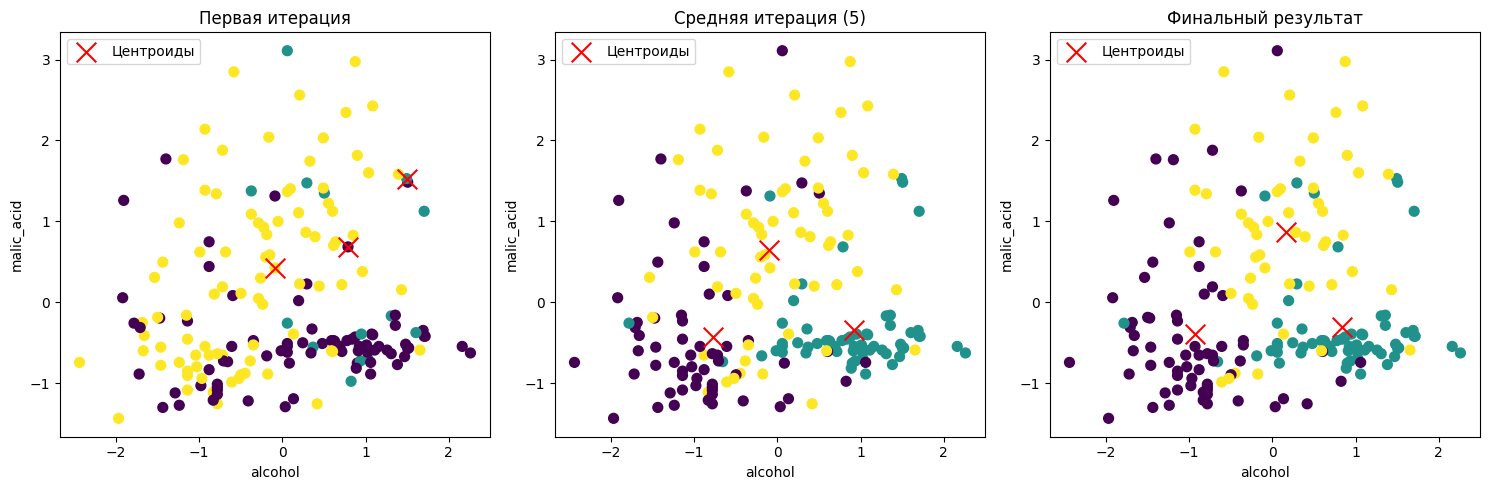

In [22]:
plt.figure(figsize=(15, 5))

# Первая итерация
plt.subplot(1, 3, 1)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=history['labels'][0], cmap='viridis', s=50)
plt.scatter(history['centroids'][0][:, 0], history['centroids'][0][:, 1], c='red', marker='x', s=200, label='Центроиды')
plt.title('Первая итерация')
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.legend()

# Средняя итерация
plt.subplot(1, 3, 2)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=history['labels'][middle_step], cmap='viridis', s=50)
plt.scatter(history['centroids'][middle_step][:, 0], history['centroids'][middle_step][:, 1], c='red', marker='x', s=200, label='Центроиды')
plt.title(f'Средняя итерация ({middle_step})')
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.legend()

# Последняя итерация
plt.subplot(1, 3, 3)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=KM_labels, cmap='viridis', s=50)
plt.scatter(final_centroids[:, 0], final_centroids[:, 1], c='red', marker='x', s=200, label='Центроиды')
plt.title('Финальный результат')
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.legend()

plt.tight_layout()
plt.show()

In [23]:
# Вывод числа итераций
print(f"Количество итераций до сходимости: {iteration_count}")

Количество итераций до сходимости: 9


## DBSCAN: Пошаговая реализация и анализ

### Описание метода
DBSCAN (Density-Based Spatial Clustering of Applications with Noise) — это неиерархический метод кластеризации, основанный на плотности данных. Он группирует точки в кластеры на основе их плотности, а точки с низкой плотностью помечает как шум (выбросы). В отличие от K-Means, DBSCAN не требует заранее задавать количество кластеров.

#### Математические основы
1. **Основные понятия:**
   - **Eps (ε)**: радиус окрестности, в пределах которого точки считаются соседями.
   - **MinPts**: минимальное число точек в окрестности Eps, чтобы точка считалась "основной" (core point).
   - **Типы точек:**
     - Основная точка: имеет не менее MinPts соседей в радиусе Eps.
     - Граничная точка: находится в радиусе Eps от основной точки, но сама не является основной.
     - Шум: точка, не являющаяся ни основной, ни граничной.

2. **Расстояние между точками:**  
   Используется евклидово расстояние: расстояние между точками a и b равно корню из суммы квадратов разностей их координат.

#### Алгоритм пошагово
1. Выбрать непосещённую точку из набора данных.
2. Если в радиусе Eps от этой точки находится не менее MinPts соседей:
   - Пометить её как основную точку.
   - Создать новый кластер и добавить все точки из её окрестности Eps.
   - Рекурсивно расширить кластер, проверяя окрестности всех основных точек.
3. Если точка не основная и не входит в кластер, пометить её как шум.
4. Повторять, пока все точки не будут посещены.

### Преимущества
- Не требует задания числа кластеров.
- Устойчив к шуму и выбросам.
- Может находить кластеры произвольной формы.

### Недостатки
- Чувствителен к выбору параметров Eps и MinPts.
- Плохо работает с данными переменной плотности.
- Вычислительная сложность O(n^2) без оптимизаций (например, индексов).

In [26]:
# 2. DBSCAN
def dbscan(X, eps, min_pts):
    n_samples = X.shape[0]
    labels = np.full(n_samples, -1)  # Изначально все точки — шум (-1)
    cluster_label = 0  # Метка текущего кластера
    
    # Список для хранения типов точек: 0 — шум, 1 — граничная, 2 — основная
    point_types = np.zeros(n_samples)
    
    # Функция для получения соседей точки
    def get_neighbors(point_idx):
        neighbors = []
        for i in range(n_samples):
            if i != point_idx and euclidean_distance(X[point_idx], X[i]) <= eps:
                neighbors.append(i)
        return neighbors
    
    # Обработка каждой точки
    for i in range(n_samples):
        if labels[i] != -1:  # Пропускаем уже посещённые точки
            continue
        
        # Находим соседей текущей точки
        neighbors = get_neighbors(i)
        
        # Если точка не основная (менее min_pts соседей)
        if len(neighbors) < min_pts:
            labels[i] = -1  # Шум
            point_types[i] = 0
        else:
            # Новая основная точка — начинаем кластер
            cluster_label += 1
            labels[i] = cluster_label
            point_types[i] = 2  # Основная точка
            
            # Расширяем кластер
            seed_set = set(neighbors)
            for neighbor in list(seed_set):
                if labels[neighbor] == -1:  # Только непосещённые точки
                    labels[neighbor] = cluster_label
                    neighbor_neighbors = get_neighbors(neighbor)
                    
                    if len(neighbor_neighbors) >= min_pts:
                        point_types[neighbor] = 2  # Основная точка
                        seed_set.update(neighbor_neighbors)  # Добавляем новых соседей
                    else:
                        point_types[neighbor] = 1  # Граничная точка
    
    return labels, point_types

In [33]:
# Анализ расстояний до k-ближайших соседей для выбора Eps
min_pts = 5
neigh = NearestNeighbors(n_neighbors=min_pts)
neigh.fit(X_scaled)
distances, _ = neigh.kneighbors(X_scaled)
k_distances = np.sort(distances[:, min_pts-1])  # Расстояния до (min_pts-1)-го соседа

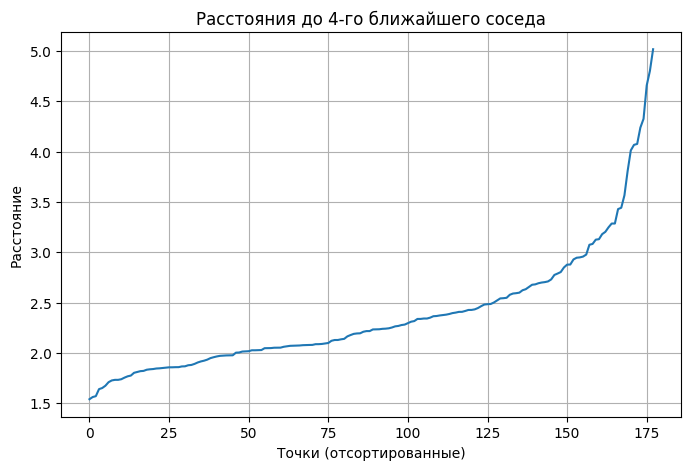

In [36]:
# Визуализация k-ближайших расстояний
plt.figure(figsize=(8, 5))
plt.plot(k_distances)
plt.title(f'Расстояния до {min_pts-1}-го ближайшего соседа')
plt.xlabel('Точки (отсортированные)')
plt.ylabel('Расстояние')
plt.grid(True)
plt.show()

In [111]:
# Запуск DBSCAN с подобранным Eps
eps = 6  # Выбрано на основе графика
DBSCAN_labels, point_types = dbscan(X_scaled, eps, min_pts)

# Подсчёт числа кластеров (исключая шум)
n_clusters = len(set(DBSCAN_labels)) - (1 if -1 in DBSCAN_labels else 0)

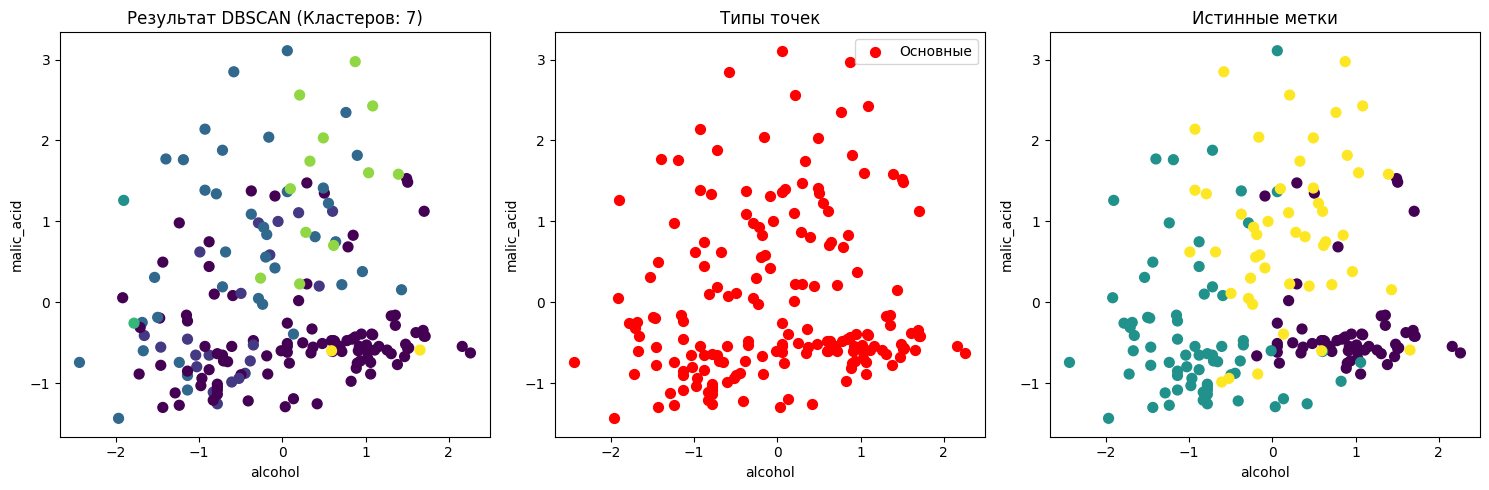

In [112]:
# Визуализация результата
plt.figure(figsize=(15, 5))

# 1. Все точки с метками кластеров
plt.subplot(1, 3, 1)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=DBSCAN_labels, cmap='viridis', s=50)
plt.title(f'Результат DBSCAN (Кластеров: {n_clusters})')
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])

# 2. Типы точек (шум, граничные, основные)
colors = {0: 'gray', 1: 'blue', 2: 'red'}  # Шум — серый, граничные — синий, основные — красный
plt.subplot(1, 3, 2)
for pt_type in np.unique(point_types):
    mask = point_types == pt_type
    plt.scatter(X_scaled[mask, 0], X_scaled[mask, 1], c=colors[pt_type], 
                label='Шум' if pt_type == 0 else 'Граничные' if pt_type == 1 else 'Основные', s=50)
plt.title('Типы точек')
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.legend()

# 3. Истинные метки для сравнения
plt.subplot(1, 3, 3)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap='viridis', s=50)
plt.title('Истинные метки')
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])

plt.tight_layout()
plt.show()

In [113]:
# Вывод информации
print(f"Количество кластеров: {n_clusters}")
print(f"Количество точек шума: {np.sum(labels == -1)}")
print(f"Количество основных точек: {np.sum(point_types == 2)}")
print(f"Количество граничных точек: {np.sum(point_types == 1)}")

Количество кластеров: 7
Количество точек шума: 0
Количество основных точек: 178
Количество граничных точек: 0


## Mean Shift: Пошаговая реализация и анализ

### Описание метода
Mean Shift — это неиерархический метод кластеризации, основанный на поиске областей максимальной плотности данных. Алгоритм итеративно сдвигает центроиды к среднему значению точек в заданной окрестности (bandwidth), пока они не стабилизируются. После сходимости близкие центроиды объединяются в кластеры. Mean Shift не требует заранее задавать число кластеров, что отличает его от K-Means.

#### Математические основы
1. **Оценка плотности (ядерная оценка):**  
   Mean Shift использует ядерную функцию (обычно гауссово ядро) для оценки плотности данных. Плотность в точке x пропорциональна сумме значений ядра для всех точек в окрестности:
   - Плотность = (1 / n) * сумма [K((x - x_i) / h)],
   где K — ядро (например, гауссово), h — ширина окна (bandwidth), x_i — точки данных, n — число точек.

2. **Сдвиг среднего:**  
   На каждой итерации центроид сдвигается к среднему значению точек, взвешенному по ядру:
   - Новый центроид = сумма [x_i * K((x - x_i) / h)] / сумма [K((x - x_i) / h)].

3. **Расстояние:**  
   Используется евклидово расстояние для определения окрестности.

#### Алгоритм пошагово
1. Инициализировать центроиды как все точки данных.
2. Для каждого центроида:
   - Найти все точки в радиусе bandwidth.
   - Вычислить новое положение центроида как среднее значение точек в окрестности (взвешенное или нет, в зависимости от ядра).
   - Сдвинуть центроид к новому положению.
3. Повторять шаг 2, пока центроиды не стабилизируются (сдвиг становится меньше порога).
4. Объединить близкие центроиды в кластеры.

### Преимущества
- Не требует задания числа кластеров.
- Адаптируется к данным через параметр bandwidth.
- Может находить кластеры произвольной формы.

### Недостатки
- Чувствителен к выбору bandwidth.
- Высокая вычислительная сложность (O(n^2) на итерацию без оптимизаций).
- Медленная сходимость для больших датасетов.

In [62]:
# Реализация Mean Shift
def mean_shift(X, bandwidth, max_iters=100, tol=1e-4):
    n_samples = X.shape[0]
    centroids = X.copy()  # Изначально центроиды — все точки
    
    # История для визуализации
    history = [centroids.copy()]
    iteration_count = 0
    
    for _ in range(max_iters):
        new_centroids = np.zeros_like(centroids)
        converged = True
        
        # Для каждого центроида
        for i in range(n_samples):
            # Находим точки в окрестности bandwidth
            weights = []
            points_in_window = []
            for j in range(n_samples):
                dist = euclidean_distance(centroids[i], X[j])
                if dist <= bandwidth:
                    # Простое равномерное ядро (1, если в окне)
                    weights.append(1)
                    points_in_window.append(X[j])
            
            if len(points_in_window) > 0:
                # Новый центроид — среднее по точкам в окне
                new_centroids[i] = np.mean(points_in_window, axis=0)
                # Проверяем сходимость
                if euclidean_distance(centroids[i], new_centroids[i]) > tol:
                    converged = False
            else:
                new_centroids[i] = centroids[i]  # Если нет точек, оставляем как есть
        
        centroids = new_centroids
        history.append(centroids.copy())
        iteration_count += 1
        
        if converged:
            break
    
    # Объединяем близкие центроиды в кластеры
    labels = np.zeros(n_samples, dtype=int)
    cluster_label = 0
    used = set()
    
    for i in range(n_samples):
        if i in used:
            continue
        labels[i] = cluster_label
        used.add(i)
        for j in range(i + 1, n_samples):
            if euclidean_distance(centroids[i], centroids[j]) < bandwidth / 2:  # Порог объединения
                labels[j] = cluster_label
                used.add(j)
        cluster_label += 1
    
    return labels, centroids, history, iteration_count

In [101]:
# Запуск Mean Shift
bandwidth = 3.5  # Ширина окна (подобрана экспериментально)
MS_labels, final_centroids, history, iteration_count = mean_shift(X_scaled, bandwidth)

# Подсчёт числа кластеров
n_clusters = len(np.unique(MS_labels))

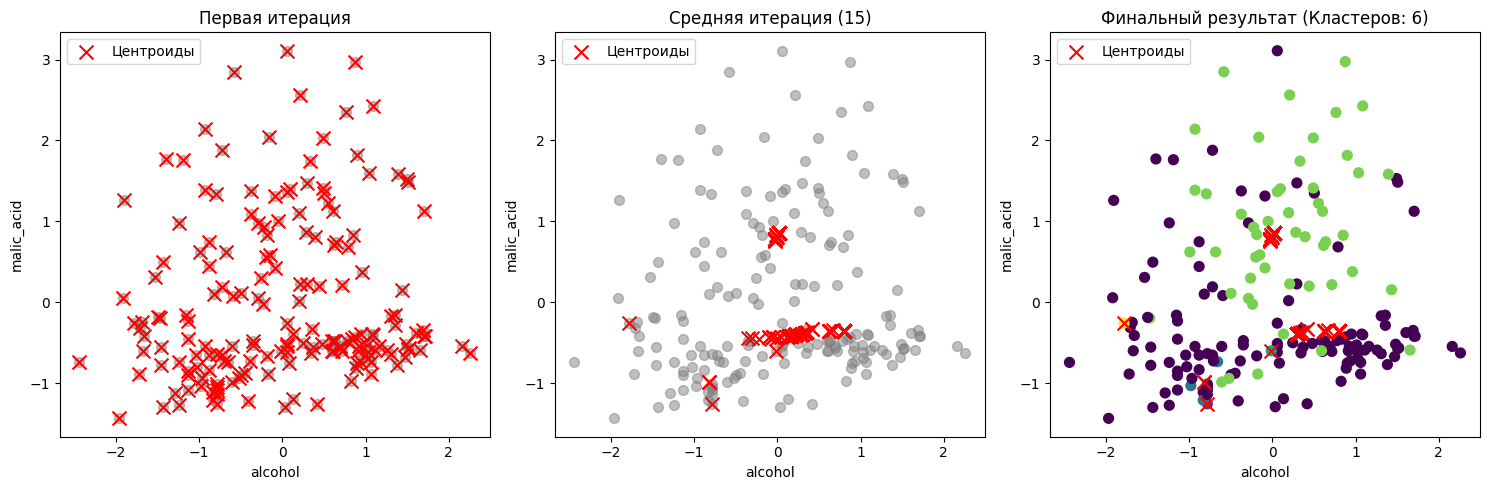

In [83]:
# Визуализация трёх стадий: первая, средняя, последняя
plt.figure(figsize=(15, 5))

# Первая итерация
plt.subplot(1, 3, 1)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c='gray', s=50, alpha=0.5)
plt.scatter(history[0][:, 0], history[0][:, 1], c='red', marker='x', s=100, label='Центроиды')
plt.title('Первая итерация')
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.legend()

# Средняя итерация
middle_step = len(history) // 2
plt.subplot(1, 3, 2)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c='gray', s=50, alpha=0.5)
plt.scatter(history[middle_step][:, 0], history[middle_step][:, 1], c='red', marker='x', s=100, label='Центроиды')
plt.title(f'Средняя итерация ({middle_step})')
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.legend()

# Финальный результат
plt.subplot(1, 3, 3)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=MS_labels, cmap='viridis', s=50)
plt.scatter(final_centroids[:, 0], final_centroids[:, 1], c='red', marker='x', s=100, label='Центроиды')
plt.title(f'Финальный результат (Кластеров: {n_clusters})')
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.legend()

plt.tight_layout()
plt.show()

In [82]:
# Вывод информации
print(f"Количество итераций до сходимости: {iteration_count}")
print(f"Количество кластеров: {n_clusters}")

Количество итераций до сходимости: 30
Количество кластеров: 6


## Gaussian Mixture Models (GMM): Пошаговая реализация и анализ

## #Описание метода
Gaussian Mixture Models (GMM) — это неиерархический вероятностный метод кластеризации, который предполагает, что данные порождены смесью нескольких гауссовых распределений. Каждому кластеру соответствует гауссова компонента с собственными параметрами (среднее, ковариация, вес). GMM использует алгоритм Expectation-Maximization (EM) для оценки этих параметров. В отличие от K-Means, GMM учитывает не только расстояние до центроида, но и форму кластеров.

#### Математические основы
1. **Модель смеси:**  
   Вероятность точки x задаётся как сумма вероятностей от k гауссовых компонент:  
   - P(x) = сумма [π_k * N(x | μ_k, Σ_k)],  
   где π_k — вес компоненты k, N(x | μ_k, Σ_k) — гауссово распределение с центром μ_k и ковариацией Σ_k.

2. **Гауссово распределение:**  
   Вероятность точки x для одной компоненты:  
   - N(x | μ, Σ) = (1 / sqrt((2π)^d * det(Σ))) * exp(-0.5 * (x - μ)^T * Σ^(-1) * (x - μ)),  
   где d — размерность данных, det(Σ) — определитель ковариационной матрицы.

3. **Алгоритм EM:**  
   - **E-шаг (Expectation):** Вычислить вероятности принадлежности каждой точки к каждой компоненте (responsibilities).  
   - **M-шаг (Maximization):** Обновить параметры компонент (μ_k, Σ_k, π_k) на основе этих вероятностей.

#### Алгоритм пошагово
1. Инициализировать параметры: центры μ_k, ковариации Σ_k и веса π_k для k компонент.
2. **E-шаг:** Для каждой точки вычислить вероятность принадлежности к каждой компоненте.
3. **M-шаг:** Обновить:
   - μ_k = среднее взвешенное по точкам с учётом их responsibilities.
   - Σ_k = взвешенная ковариация точек относительно μ_k.
   - π_k = доля точек, приписанных к компоненте k.
4. Повторять шаги 2–3, пока параметры не стабилизируются.

### Преимущества
- Учитывает форму и разброс кластеров (в отличие от K-Means).
- Вероятностная модель позволяет оценивать неопределённость.
- Гибкость в определении кластеров.

### Недостатки
- Требует задания числа компонент k.
- Чувствителен к начальной инициализации.
- Вычислительно сложен для больших данных.

In [84]:
# Функция для вычисления гауссовой плотности
def gaussian_pdf(x, mean, cov):
    d = x.shape[0]
    diff = x - mean
    cov_det = np.linalg.det(cov)
    cov_inv = np.linalg.inv(cov)
    exponent = -0.5 * diff.T @ cov_inv @ diff
    norm = 1 / np.sqrt((2 * np.pi) ** d * cov_det)
    return norm * np.exp(exponent)

# Реализация GMM с EM-алгоритмом
def gmm(X, n_components, max_iters=100, tol=1e-4, random_seed=42):
    np.random.seed(random_seed)
    n_samples, n_features = X.shape
    
    # Инициализация параметров
    idx = np.random.choice(n_samples, n_components, replace=False)
    means = X[idx]  # Центры
    covariances = np.array([np.cov(X.T) for _ in range(n_components)])  # Ковариации
    weights = np.ones(n_components) / n_components  # Веса
    
    # История для визуализации
    history = {'means': [means.copy()], 'labels': []}
    iteration_count = 0
    
    for _ in range(max_iters):
        # E-шаг: вычисление responsibilities
        responsibilities = np.zeros((n_samples, n_components))
        for k in range(n_components):
            for i in range(n_samples):
                responsibilities[i, k] = weights[k] * gaussian_pdf(X[i], means[k], covariances[k])
        responsibilities /= responsibilities.sum(axis=1, keepdims=True)
        
        # Предсказание меток для визуализации
        labels = np.argmax(responsibilities, axis=1)
        history['labels'].append(labels.copy())
        
        # M-шаг: обновление параметров
        Nk = responsibilities.sum(axis=0)  # Сумма responsibilities для каждой компоненты
        
        # Обновление центров
        new_means = np.zeros_like(means)
        for k in range(n_components):
            new_means[k] = np.sum(responsibilities[:, k, np.newaxis] * X, axis=0) / Nk[k]
        
        # Обновление ковариаций
        new_covariances = np.zeros_like(covariances)
        for k in range(n_components):
            diff = X - new_means[k]
            new_covariances[k] = (responsibilities[:, k, np.newaxis] * diff).T @ diff / Nk[k]
            # Регуляризация для избежания сингулярности
            new_covariances[k] += np.eye(n_features) * 1e-6
        
        # Обновление весов
        new_weights = Nk / n_samples
        
        # Проверка сходимости
        if np.all(np.abs(new_means - means) < tol) and np.all(np.abs(new_covariances - covariances) < tol):
            break
        
        means = new_means
        covariances = new_covariances
        weights = new_weights
        history['means'].append(means.copy())
        iteration_count += 1
    
    return labels, means, covariances, weights, history, iteration_count

In [99]:
# Запуск GMM
n_components = 3  # Число компонент
GMM_labels, final_means, final_covariances, final_weights, history, iteration_count = gmm(X_scaled, n_components)

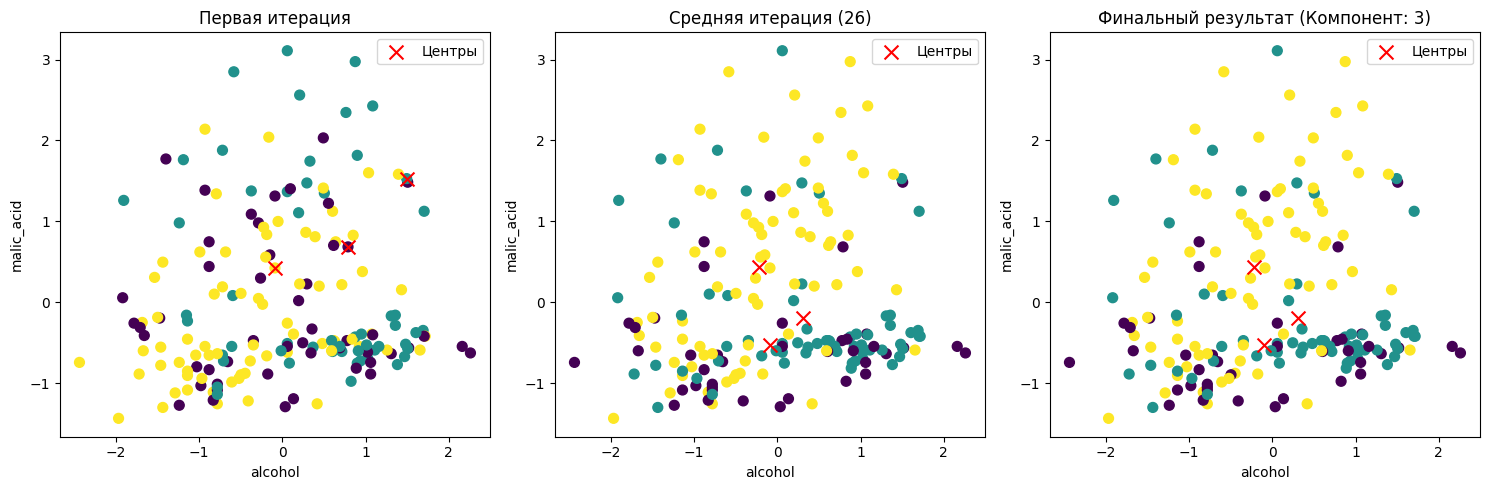

In [87]:
# Визуализация трёх стадий: первая, средняя, последняя
plt.figure(figsize=(15, 5))

# Первая итерация
plt.subplot(1, 3, 1)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=history['labels'][0], cmap='viridis', s=50)
plt.scatter(history['means'][0][:, 0], history['means'][0][:, 1], c='red', marker='x', s=100, label='Центры')
plt.title('Первая итерация')
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.legend()

# Средняя итерация
middle_step = len(history['labels']) // 2
plt.subplot(1, 3, 2)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=history['labels'][middle_step], cmap='viridis', s=50)
plt.scatter(history['means'][middle_step][:, 0], history['means'][middle_step][:, 1], c='red', marker='x', s=100, label='Центры')
plt.title(f'Средняя итерация ({middle_step})')
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.legend()

# Финальный результат
plt.subplot(1, 3, 3)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=GMM_labels, cmap='viridis', s=50)
plt.scatter(final_means[:, 0], final_means[:, 1], c='red', marker='x', s=100, label='Центры')
plt.title(f'Финальный результат (Компонент: {n_components})')
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.legend()

plt.tight_layout()
plt.show()

In [88]:
# Вывод информации
print(f"Количество итераций до сходимости: {iteration_count}")
print(f"Веса компонент: {final_weights}")

Количество итераций до сходимости: 51
Веса компонент: [0.22104047 0.36031569 0.41864384]


## Spectral Clustering: Пошаговая реализация и анализ

### Описание метода
Spectral Clustering — это неиерархический метод кластеризации, который использует спектральные свойства матрицы сходства данных (обычно основанной на расстояниях). Он преобразует данные в пространство меньшей размерности с помощью собственных векторов лапласиана графа, а затем применяет кластеризацию (например, K-Means) в этом пространстве. Метод особенно эффективен для кластеров сложной формы, где традиционные методы, такие как K-Means, могут не справляться.

#### Математические основы
1. **Матрица сходства (Affinity Matrix):**  
   Для каждой пары точек вычисляется сходство, например, с использованием гауссова ядра:  
   - A[i, j] = exp(-||x_i - x_j||^2 / (2 * σ^2)),  
   где σ — параметр масштаба, ||x_i - x_j|| — евклидово расстояние.

2. **Матрица степени (Degree Matrix):**  
   Диагональная матрица D, где D[i, i] = сумма A[i, j] по всем j (степень вершины i).

3. **Лапласиан графа:**  
   Нормализованный лапласиан L = I - D^(-1/2) * A * D^(-1/2),  
   где I — единичная матрица.

4. **Спектральное разложение:**  
   Находятся k собственных векторов, соответствующих k наименьшим ненулевым собственным значениям L. Эти векторы формируют новое представление данных.

5. **Кластеризация:**  
   Применяется K-Means к полученным векторам для разделения на кластеры.

#### Алгоритм пошагово
1. Построить матрицу сходства A на основе расстояний между точками.
2. Вычислить матрицу степени D.
3. Построить нормализованный лапласиан L.
4. Найти k собственных векторов L, соответствующих k наименьшим ненулевым собственным значениям.
5. Использовать эти векторы как новое представление данных и применить K-Means.

### Преимущества
- Хорошо работает с кластерами сложной формы.
- Не предполагает сферическую структуру данных (в отличие от K-Means).
- Эффективен для данных с нелинейной разделимостью.

### Недостатки
- Требует задания числа кластеров k.
- Чувствителен к параметру σ (масштаб ядра).
- Вычислительно сложен из-за разложения матрицы (O(n^3) для полного спектра).

In [89]:
# Реализация Spectral Clustering
def spectral_clustering(X, n_clusters, sigma=1.0):
    n_samples = X.shape[0]
    
    # 1. Построение матрицы сходства (Affinity Matrix)
    A = np.zeros((n_samples, n_samples))
    for i in range(n_samples):
        for j in range(i, n_samples):  # Симметричная матрица
            dist = euclidean_distance(X[i], X[j])
            similarity = np.exp(-dist**2 / (2 * sigma**2))
            A[i, j] = similarity
            A[j, i] = similarity
    
    # 2. Матрица степени (Degree Matrix)
    D = np.diag(np.sum(A, axis=1))
    
    # 3. Нормализованный лапласиан
    D_inv_sqrt = np.diag(1.0 / np.sqrt(np.diag(D)))
    L = np.eye(n_samples) - D_inv_sqrt @ A @ D_inv_sqrt
    
    # 4. Спектральное разложение
    eigenvalues, eigenvectors = np.linalg.eigh(L)
    # Берем k собственных векторов, соответствующих наименьшим ненулевым значениям
    idx = np.argsort(eigenvalues)[1:n_clusters+1]  # Пропускаем 0-е значение
    spectral_features = eigenvectors[:, idx]
    
    # 5. Применение K-Means к спектральным признакам
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(spectral_features)
    centroids = kmeans.cluster_centers_
    
    return labels, spectral_features, centroids

In [98]:
# Запуск Spectral Clustering
n_clusters = 3  # Число кластеров
sigma = 2  # Параметр гауссова ядра
SC_labels, spectral_features, centroids = spectral_clustering(X_scaled, n_clusters, sigma)

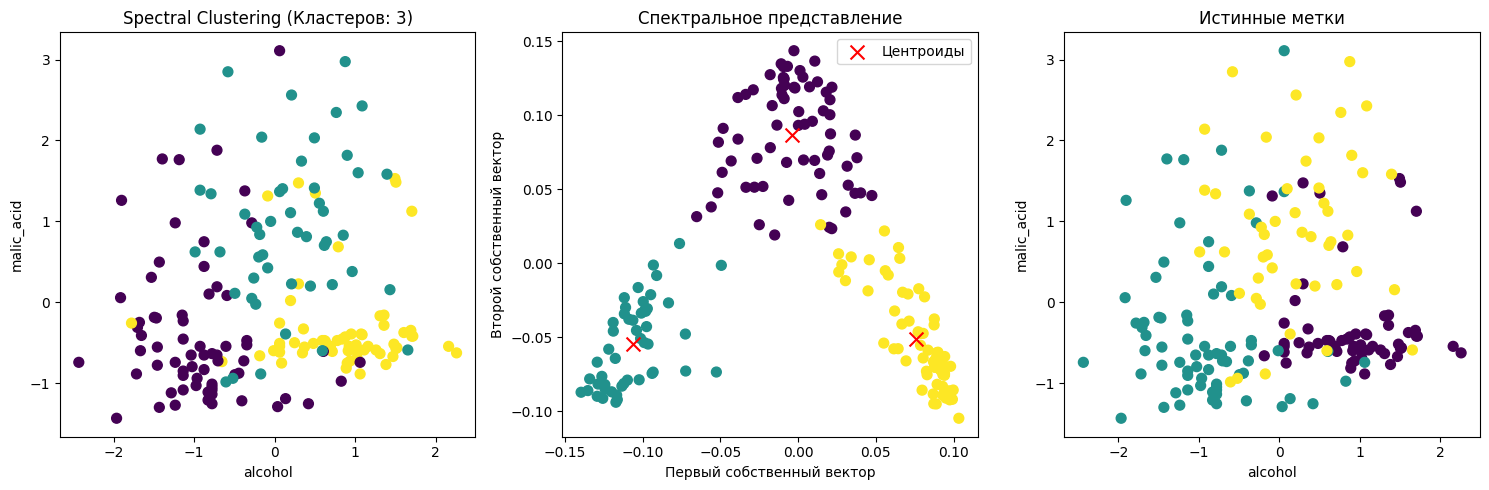

In [94]:
# Визуализация результатов
plt.figure(figsize=(15, 5))

# 1. Исходные данные с метками кластеров
plt.subplot(1, 3, 1)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=SC_labels, cmap='viridis', s=50)
plt.title(f'Spectral Clustering (Кластеров: {n_clusters})')
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])

# 2. Спектральное представление (первые два собственных вектора)
plt.subplot(1, 3, 2)
plt.scatter(spectral_features[:, 0], spectral_features[:, 1], c=SC_labels, cmap='viridis', s=50)
plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=100, label='Центроиды')
plt.title('Спектральное представление')
plt.xlabel('Первый собственный вектор')
plt.ylabel('Второй собственный вектор')
plt.legend()

# 3. Истинные метки для сравнения
plt.subplot(1, 3, 3)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap='viridis', s=50)
plt.title('Истинные метки')
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])

plt.tight_layout()
plt.show()

## Сравнение неиерархических методов кластеризации

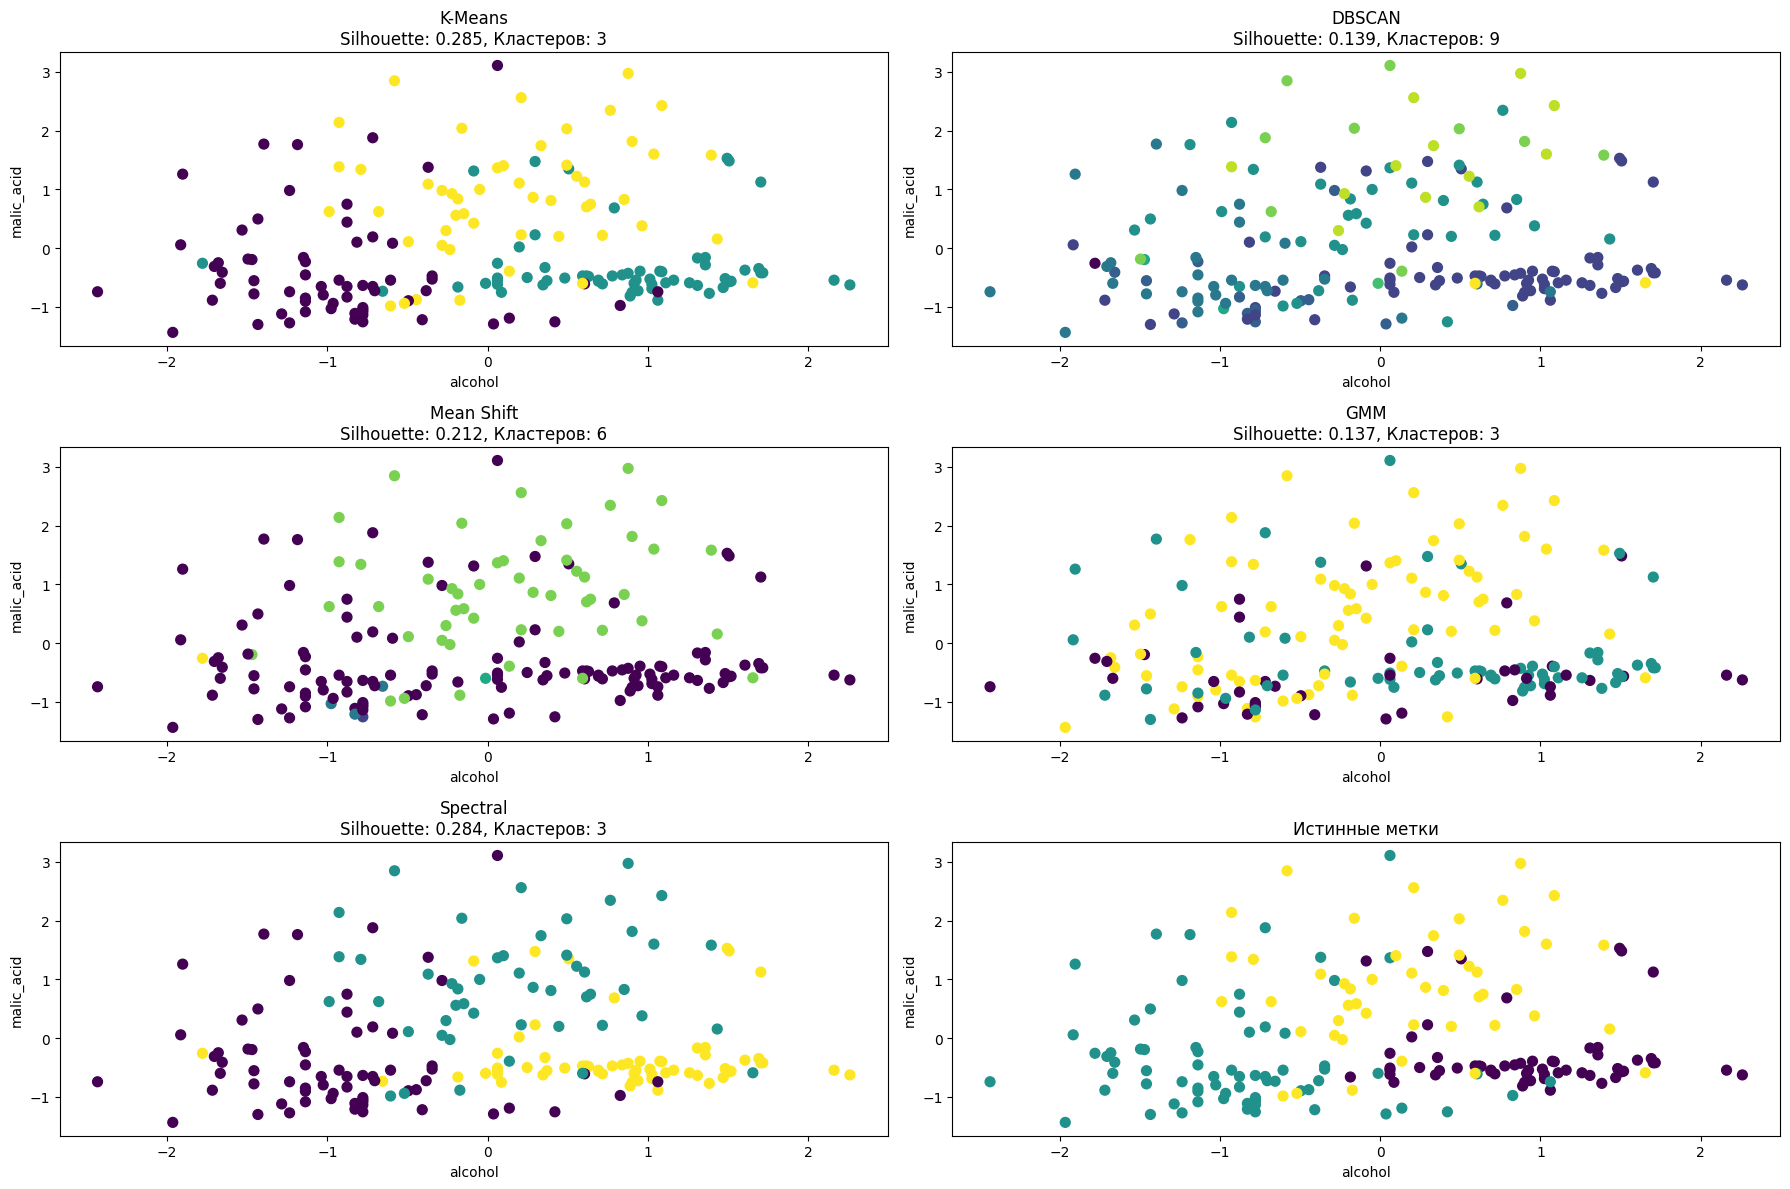

Сравнение методов:
K-Means: Silhouette Score = 0.285, Число кластеров = 3
DBSCAN: Silhouette Score = 0.139, Число кластеров = 9
Mean Shift: Silhouette Score = 0.212, Число кластеров = 6
GMM: Silhouette Score = 0.137, Число кластеров = 3
Spectral: Silhouette Score = 0.284, Число кластеров = 3


In [104]:
# Предполагаемые результаты от предыдущих реализаций
# Замените имена переменных на свои, если они отличаются
methods = {
    'K-Means': (KM_labels, final_centroids),
    'DBSCAN': (DBSCAN_labels, point_types),
    'Mean Shift': (MS_labels, final_centroids),
    'GMM': (GMM_labels, final_means),
    'Spectral': (SC_labels, centroids)
}

# Подсчёт метрик и визуализация
plt.figure(figsize=(18, 12))
sil_scores = {}
n_clusters_dict = {}

for i, (name, (labels, _)) in enumerate(methods.items(), 1):
    # Подсчёт числа кластеров
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    n_clusters_dict[name] = n_clusters
    
    # Silhouette Score (только если больше одного кластера)
    if n_clusters > 1:
        sil_score = silhouette_score(X_scaled, labels)
    else:
        sil_score = -1  # Не применимо
    sil_scores[name] = sil_score
    
    # Визуализация
    plt.subplot(3, 2, i)
    plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=labels, cmap='viridis', s=50)
    plt.title(f'{name}\nSilhouette: {sil_score:.3f}, Кластеров: {n_clusters}')
    plt.xlabel(feature_names[0])
    plt.ylabel(feature_names[1])

# Истинные метки
plt.subplot(3, 2, 6)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y, cmap='viridis', s=50)
plt.title('Истинные метки')
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])

plt.tight_layout()
plt.show()

# Вывод результатов
print("Сравнение методов:")
for name in methods:
    print(f"{name}: Silhouette Score = {sil_scores[name]:.3f}, Число кластеров = {n_clusters_dict[name]}")